# Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Unzip
import zipfile
with zipfile.ZipFile("/content/gdrive/MyDrive/data_extract.zip","r") as zip_ref:
    zip_ref.extractall()

In [ ]:
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
data_dir = pathlib.Path('/content/content/data_extract')

In [ ]:
all_image_paths = list(data_dir.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths[0]

'/content/content/data_2_extract/surprise/151801.jpg'

In [ ]:
all_labels = list(map(lambda x: x.split('/')[-2], all_image_paths))
all_labels[0]

'surprise'

In [ ]:
label_names = sorted(item.name for item in data_dir.glob('*/') if item.is_dir())
label_names

['angry', 'happy', 'neutral', 'sad', 'surprise']

In [ ]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4}

In [ ]:
# all in one go
all_image_labels = [label_to_index[label]
                    for label in all_labels]

print("First 5 labels indices: ", all_image_labels[:5])
print("First 5 paths: ")
all_image_paths[:5]

First 5 labels indices:  [4, 4, 4, 4, 4]
First 5 paths: 


['/content/content/data_2_extract/surprise/151801.jpg',
 '/content/content/data_2_extract/surprise/332278.jpg',
 '/content/content/data_2_extract/surprise/20561.jpg',
 '/content/content/data_2_extract/surprise/316794.jpg',
 '/content/content/data_2_extract/surprise/73719.jpg']

In [ ]:
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(all_image_paths, all_image_labels,
												test_size=0.1, shuffle = True,
												stratify = all_image_labels, random_state = 42)


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_ds   = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [ ]:
def preprocess_image(image):
    image = tf.io.decode_jpeg(image,channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image/ 255.0  # normalize to [0,1] range
    return image

def load_and_preprocess_image(path, label):
    image_raw = tf.io.read_file(path)
    image = preprocess_image(image_raw)
    return image, label

In [ ]:
train_ds = train_ds.map(load_and_preprocess_image).shuffle(1000,seed=42).batch(32).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.map(load_and_preprocess_image).batch(32).prefetch(buffer_size= tf.data.AUTOTUNE)

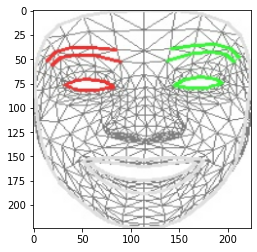

In [ ]:
image, label = next(iter(train_ds.take(1)))
plt.imshow(image[0])

# Use data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
	tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
 	tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

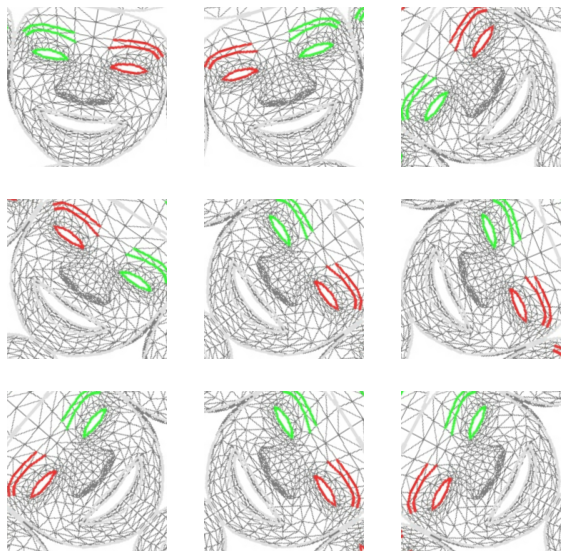

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

# Build the model

In [ ]:
train_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet",
                                              input_shape=(224, 224, 3), 
                                              include_top=False)
# Freeze the base model
base_model.trainable= True

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
def model_maker():
  inputs = tf.keras.Input(shape=(224,224, 3))
  x = data_augmentation(inputs)
  x = base_model(x, training=True)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  outputs =  tf.keras.layers.Dense(5, activation='softmax')(x)
  model = tf.keras.Model(inputs, outputs)
  return model

In [ ]:
model = model_maker()

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 2,230,277
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          restore_best_weights=True,
                                                          min_delta=1e-2,
                                                          patience=10,
                                                          verbose=1)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="/content/gdrive/MyDrive/final_project_model_save/MobileNetV2_{epoch}.h5",
                                                        save_weights_only=False, # the whole model (False) or only weights (True) 
                                                        save_best_only=True, # keep the best model with lowest validation loss
                                                        monitor='val_loss',
                                                        verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.001)
callbacks = [earlystopping_callback,checkpoint_callback, reduce_lr]

In [ ]:
epochs=100

history = model.fit(train_ds,               # <<<<<<<
                    validation_data=val_ds, # <<<<<<<
                    epochs=epochs, verbose =1,
                    callbacks = callbacks)

Epoch 1/100
2159/2159 [==============================] - 375s 170ms/step - loss: 1.2554 - accuracy: 0.4676 - val_loss: 1.1989 - val_accuracy: 0.4939

Epoch 00001: val_loss improved from inf to 1.19890, saving model to /content/gdrive/MyDrive/final_project_model_save/MobileNetV2_1.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
2159/2159 [==============================] - 367s 169ms/step - loss: 1.1910 - accuracy: 0.4977 - val_loss: 1.1744 - val_accuracy: 0.5055

Epoch 00002: val_loss improved from 1.19890 to 1.17439, saving model to /content/gdrive/MyDrive/final_project_model_save/MobileNetV2_2.h5
Epoch 3/100
2159/2159 [==============================] - 367s 170ms/step - loss: 1.1771 - accuracy: 0.5037 - val_loss: 1.1646 - val_accuracy: 0.5099

Epoch 00003: val_loss improved from 1.17439 to 1.16458, saving model to /content/gdrive/MyDrive/final_project_model_save/MobileNetV2_3.h5
Epoch 4/100
2159/2159 [==============================] - 367s 170ms/step - loss: 1.1583 - accuracy: 0.5130 - val_loss: 1.1488 - val_accuracy: 0.5152

Epoch 00004: val_loss improved from 1.16458 to 1.14883, saving model to /content/gdrive/MyDrive/final_project_model_save/MobileNetV2_4.h5
Epoch 5/100
2159/2159 [==============================] - 367s 169ms/step - loss: 1.1451 - accuracy: 0.5185 - val_loss: 1.1413 - val_accu

In [ ]:
restored_model = tf.keras.models.load_model('/content/gdrive/MyDrive/final_project_model_save/MobileNetV2_30.h5')

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.1,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])